In [6]:
## all the below, plus one modification: response variable is number of patients that arrived during last time step.
## this is a better response variable than the one used in predict1.ipynb because 
## it is independent of the number of staff and beds available

#LSTM model made with weather data 
#this version predicts PS load as a function of many variables, including weather.
#using the parameters below, we get reasonably good performance:
# 1 LSTM neuron, 16 trainable parameters, prediction_length = 48, num_epochs = 500 #1000 epochs
#learning_rate = 0.001 #0.001 lr
#input_size = 74 #number of features
#hidden_size = 16 #number of features in hidden state
#num_layers = 1 #number of stacked lstm layers
#num_classes = 1 #number of output classes
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('df PS and weather.csv', index_col = 0, parse_dates=True)

In [7]:

df.head()

,num_pazienti_in_attesa_totale_colori,num_pazienti24ore_totale_colori,num_pazienti24ore_bianchi,num_pazienti24ore_verdi,num_pazienti24ore_gialli,num_pazienti24ore_rossi,num_pazienti_giorno_totale_colori,num_pazienti_giorno_bianchi,num_pazienti_giorno_verdi,num_pazienti_giorno_gialli,...,solarenergy,uvindex,severerisk,Clear,Overcast,Partially cloudy,Rain,"Rain, Overcast","Rain, Partially cloudy",rain
2022-02-11 00:00:00,6.40,111.80,0.0,72.8,34.00,5.0,1.00,0.0,0.0,1.00,...,0.0,0.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-11 00:15:00,4.00,111.00,0.0,72.0,34.00,5.0,1.00,0.0,0.0,1.00,...,0.0,0.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-11 00:30:00,2.80,111.00,0.0,72.0,34.00,5.0,1.00,0.0,0.0,1.00,...,0.0,0.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-11 00:45:00,2.00,111.00,0.0,72.0,34.00,5.0,1.00,0.0,0.0,1.00,...,0.0,0.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-11 01:00:00,2.75,111.75,0.0,72.0,34.75,5.0,1.75,0.0,0.0,1.75,...,0.0,0.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: title={'center': 'Catania Weather Data'}>

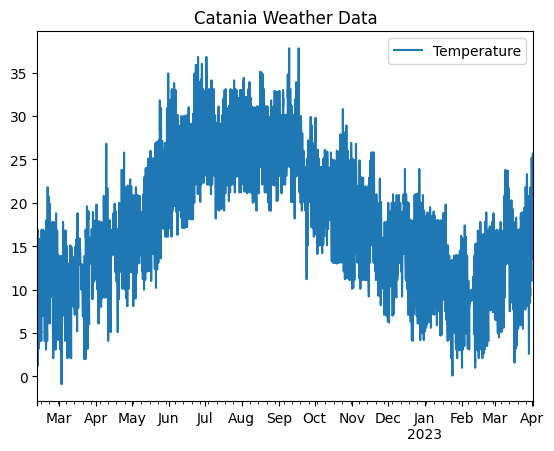

In [8]:

df['temp'].plot(label='Temperature', title='Catania Weather Data', legend=True)


In [9]:
df.index

DatetimeIndex(['2022-02-11 00:00:00', '2022-02-11 00:15:00',
               '2022-02-11 00:30:00', '2022-02-11 00:45:00',
               '2022-02-11 01:00:00', '2022-02-11 01:15:00',
               '2022-02-11 01:30:00', '2022-02-11 01:45:00',
               '2022-02-11 02:00:00', '2022-02-11 02:15:00',
               ...
               '2023-04-01 20:45:00', '2023-04-01 21:00:00',
               '2023-04-01 21:15:00', '2023-04-01 21:30:00',
               '2023-04-01 21:45:00', '2023-04-01 22:00:00',
               '2023-04-01 22:15:00', '2023-04-01 22:30:00',
               '2023-04-01 22:45:00', '2023-04-01 23:00:00'],
              dtype='datetime64[ns]', length=39837, freq=None)

In [11]:
# make variable x = all columns of df except first column  
X = df.iloc[:, 1:] #everything except first column
y = df.iloc[:, 0:1] #select response variable

y.head()
# X.shape

,num_pazienti_in_attesa_totale_colori
2022-02-11 00:00:00,6.40
2022-02-11 00:15:00,4.00
2022-02-11 00:30:00,2.80
2022-02-11 00:45:00,2.00
2022-02-11 01:00:00,2.75


In [12]:

from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()


X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 

#first 30000 for training

X_train = X_ss[:35000, :]
X_test = X_ss[35000:, :]

y_train = y_mm[:35000, :]
y_test = y_mm[35000:, :] 

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (35000, 74) (35000, 1)
Testing Shape (4837, 74) (4837, 1)


In [28]:
# X_train
# X_test
# y_train
y_test

array([[0.52212578],
       [0.53161997],
       [0.5347847 ],
       ...,
       [0.51896105],
       [0.52845524],
       [0.55298189]])

In [13]:
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

#reshaping to rows, timestamps, features

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))


X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([35000, 1, 74]) torch.Size([35000, 1])
Testing Shape torch.Size([4837, 1, 74]) torch.Size([4837, 1])


In [49]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [16]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.01 #0.001 lr

input_size = 74 #number of features
hidden_size = 64 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

In [17]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class 

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 

for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
 
  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))



/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch: 0, loss: 0.30722
Epoch: 100, loss: 0.00026
Epoch: 200, loss: 0.00008
Epoch: 300, loss: 0.00004
Epoch: 400, loss: 0.00003
Epoch: 500, loss: 0.00002
Epoch: 600, loss: 0.00001
Epoch: 700, loss: 0.00001
Epoch: 800, loss: 0.00001
Epoch: 900, loss: 0.00001


In [18]:
df_X_ss = ss.transform(df.iloc[:, 1:]) #old transformers
df_y_mm = mm.transform(df.iloc[:, 0:1]) #old transformers

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1])) 

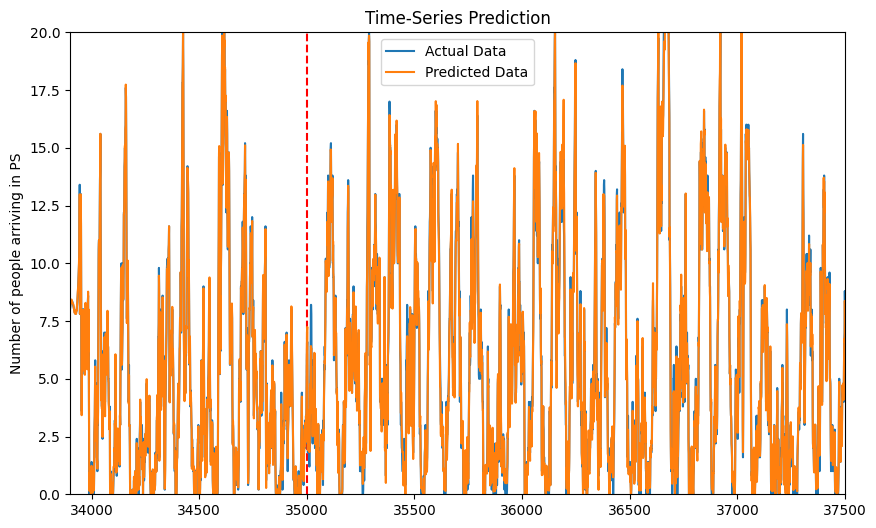

In [21]:


train_predict = lstm1(df_X_ss)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=35000, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actual Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.ylabel('Number of people arriving in PS')
plt.legend()


ax = plt.gca()
xmin = 33900  
xmax = 37500
ymin = 0
ymax = 20
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

plt.show() 

In [22]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

#smooth using moving average
averaged_Y = moving_average(dataY_plot, 5)
averaged_pred = moving_average(data_predict, 5) 


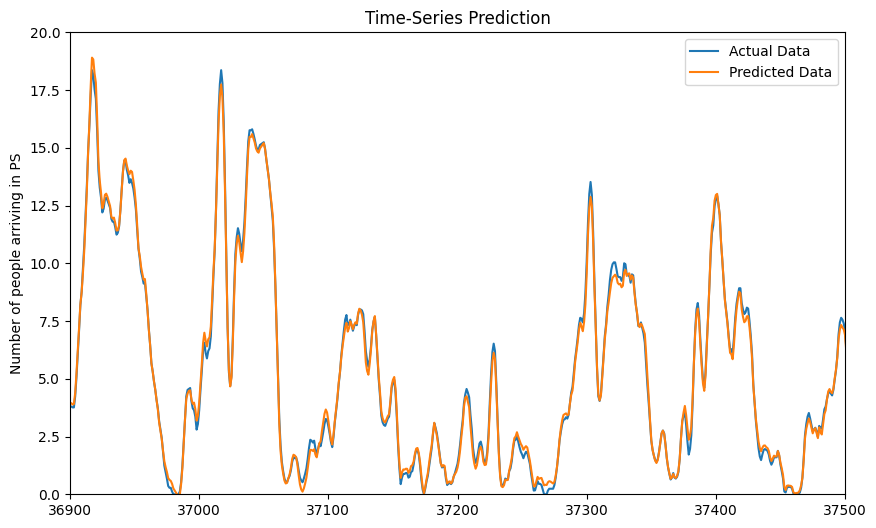

In [24]:

plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=35000, c='r', linestyle='--') #size of the training set

plt.plot(averaged_Y, label='Actual Data') #actual plot
plt.plot(averaged_pred, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.ylabel('Number of people arriving in PS')
plt.legend()


ax = plt.gca()
xmin = 36900  
xmax = 37500
ymin = 0
ymax = 20
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

plt.show() 

In [30]:
df.keys()

Index(['num_pazienti_in_attesa_totale_colori',
       'num_pazienti24ore_totale_colori', 'num_pazienti24ore_bianchi',
       'num_pazienti24ore_verdi', 'num_pazienti24ore_gialli',
       'num_pazienti24ore_rossi', 'num_pazienti_giorno_totale_colori',
       'num_pazienti_giorno_bianchi', 'num_pazienti_giorno_verdi',
       'num_pazienti_giorno_gialli', 'num_pazienti_giorno_rossi',
       'num_pazienti_in_carico_totale_colori',
       'num_pazienti_in_carico_bianchi', 'num_pazienti_in_carico_verdi',
       'num_pazienti_in_carico_gialli', 'num_pazienti_in_carico_rossi',
       'num_pazienti_in_attesa_bianchi', 'num_pazienti_in_attesa_verdi',
       'num_pazienti_in_attesa_gialli', 'num_pazienti_in_attesa_rossi',
       'num_pazienti_in_trattamento_totale_colori',
       'num_pazienti_in_trattamento_bianchi',
       'num_pazienti_in_trattamento_verdi',
       'num_pazienti_in_trattamento_gialli',
       'num_pazienti_in_trattamento_rossi', 'num_pazienti_one_to_one',
       'num_pazienti_

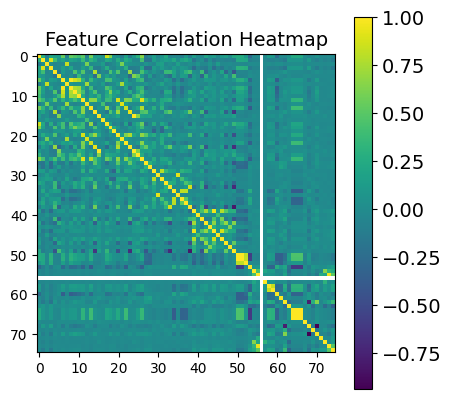

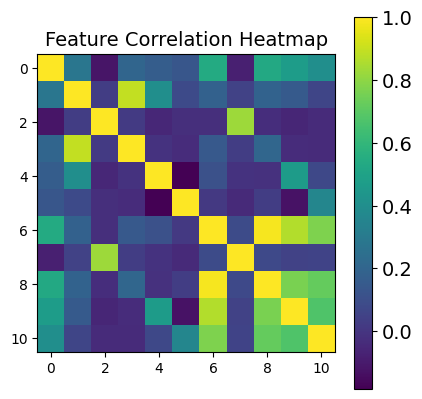

In [43]:
#too good to be true. I bet the response variable is directly correlated with some of the predictors. Let's see

def show_heatmap(data):
    plt.matshow(data.corr())
    # plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    # plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()

d = df.iloc[:, :11] #looks like column 8 is 100% correlated with the response variable 0... let's get rid of it and redo
show_heatmap(df) 
show_heatmap(d) 

So now we go to a new file, predict4.ipynb, to selectively remove some columns.